In [1]:
import os
from pathlib import Path

#auto load the eemeter module
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
import time

from hourly_test_utils import *
from applied_data_science.bigquery.data import Meter_Data
from eemeter import eemeter as em
from eemeter.common.metrics import BaselineTestingMetrics as Metrics

import multiprocessing as mp


In [2]:
settings = em.HourlySettings(
    TRAIN_FEATURES=['ghi'],
    ALPHA=0.1,
    L1_RATIO=0.1,
    SEED=42
)

In [42]:
def obj_fcn(X, gradient=np.array([])):
    timer_start = time.time()

    # X = np.array(X)
    # X[0] = 10**X[0] # alpha comes as log(alpha)
    alpha, l1_ratio = X

    
    prf.settings.ALPHA = alpha
    prf.settings.L1_RATIO = l1_ratio
    
    prf.run()
    
    obj = 0
    count = 0
    all_test_errors = []
    for res in prf.results:
        _, _, errors = res
        if (errors!=None) and (errors['train'][0]!= np.inf) and (errors['test'][0]!= np.inf):
            all_test_errors.append(errors['test'][0])

    # anomaly detection in all_test_errors with 3 sigma rule
    mean = np.mean(all_test_errors)
    std = np.std(all_test_errors)
    anomalies_count = 0
    anomaly_errors = []
    for error in all_test_errors:
        if error < mean + 3*std:
            obj += error
            count += 1
        else:
            anomalies_count += 1
            anomaly_errors.append(error)
    if count == 0:
        obj = np.inf
    else:
        obj /= count
    print(f"alpha: {alpha}, l1_ratio: {l1_ratio}, obj: {obj}, count: {count}, anomalies_count: {anomalies_count}, mean: {mean}, std: {std}, anomalies: {anomaly_errors}")
    
    print(f"Time taken: {time.time()-timer_start}")
    return float(obj)
    

In [46]:
# Optimization settings
opt_options = {
    "global": {"algorithm": "RBFOpt", 
               "stop_criteria_type": 'Iteration Maximum', 
               "stop_criteria_val": 2, 
               "initial_step": 0.01, # percentage},
               "xtol_rel": 1E-5,
               "ftol_rel": 1E-5,
               "initial_pop_multiplier": 2,
    },
    # "local":  {"algorithm": "nlopt_SBPLX", 
    #            "stop_criteria_type": 'Iteration Maximum', 
    #            "stop_criteria_val": 1000, 
    #            "initial_step": 0.15, # percentage},
    #            "xtol_rel": 1E-5,
    #            "ftol_rel": 1E-5,
    # },
}
subsamples = [3]
solar_meters = [False]
kwargs = {
    'settings': settings,
    'subsamples': subsamples,
    'solar_meters': solar_meters,
    'mp' : True,
    'max_id': -1
}
prf = Population_Run_Features(**kwargs)
prf._load_data()

Max value: 151.36000061035156
Index: 3128


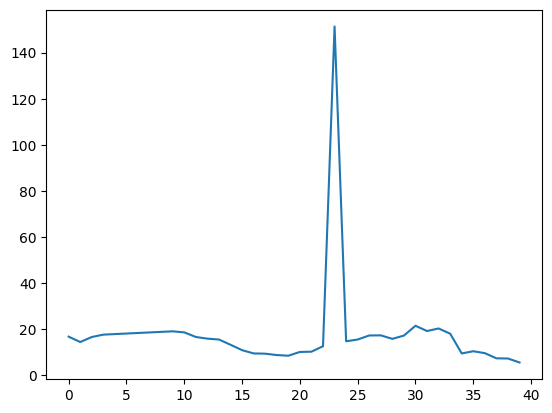

In [38]:
# subsamples = [1, 2, 3, 4, 5, 6]
# solar_meters = [True, False]
# kwargs = {
#     'settings': settings,
#     'subsamples': subsamples,
#     'solar_meters': solar_meters,
#     'mp' : True,
#     'max_id': -1
# }
# prf = Population_Run_Features(**kwargs)
# prf._load_data()
# read data to search for anomalies
all_max = []
# for idx in range(len(prf.arglist)):
for idx in [3128]:

    data = prf.arglist[idx][-2]
    # X_train, y_train, y_scaler, to = data["X_train"], data["y_train"], data["y_scaler"], data["train_observed"]
    to = data["test_observed"]
    all_max.append(to.max())

    if np.abs(to.max()) > 100:
        plt.plot(to[8000:8040])
        print(f"Max value: {to.max()}")
        print(f"Index: {idx}")
        plt.show()


In [47]:
x0 = [0.01, 0.01]
bnds = [(0.0001, 1), (0.0001, 1)]

In [48]:
import rbfopt

bnds = np.array(bnds).T
n_dim = np.size(bnds[0])

var_type = ['R']*n_dim  
max_eval = 500
max_time = 1E30
rbfopt_initialize = True
bb = rbfopt.RbfoptUserBlackBox(n_dim, np.array(bnds[0]), np.array(bnds[1]),
                                np.array(var_type), obj_fcn)


bonmin_path = "/app/applied_data_science/tools/optimization/coin-or/bonmin"
ipopt_path = "/app/applied_data_science/tools/optimization/coin-or/ipopt"
rbfsettings = rbfopt.RbfoptSettings(max_iterations=max_eval,
                                    max_evaluations=max_eval,
                                    max_cycles=1E30,
                                    max_clock_time=max_time,
                                    minlp_solver_path=bonmin_path, 
                                    nlp_solver_path=ipopt_path,)
                                    
algo = rbfopt.RbfoptAlgorithm(rbfsettings, bb, init_node_pos=x0, do_init_strategy=rbfopt_initialize)

loss, x_opt, itercount, evalcount, fast_evalcount = algo.optimize()


  Iter  Cycle  Action             Objective value      Time      Gap
  ----  -----  ------             ---------------      ----      ---


alpha: 0.8933293121402434, l1_ratio: 0.9928424438308557, obj: 1.498502840766613, count: 2982, anomalies_count: 12, mean: 9.015036805319653, std: 163.95549537600132, anomalies: [615.3295695075929, 644.4472684687241, 3642.706699022025, 622.0603841818152, 2308.4077885435945, 611.603641795681, 630.6304774360974, 4872.317093452333, 5759.144826655148, 1578.9474865950585, 619.2088089762641, 617.6806793266629]
Time taken: 67.79907965660095
alpha: 0.20460039476721156, l1_ratio: 0.014354871993423324, obj: 1.4561063658270241, count: 2982, anomalies_count: 12, mean: 9.00025799493597, std: 164.0598748688747, anomalies: [617.9276490668052, 673.5560519974392, 3642.9679332634964, 625.1662116982607, 2310.6303210994747, 624.4596937332384, 645.4540762936458, 4870.933466793658, 5758.475969868689, 1582.5022123600017, 632.8866541636484, 619.7030136037502]
Time taken: 91.64644074440002
alpha: 0.50005, l1_ratio: 0.50005, obj: 1.4729209998955, count: 2982, anomalies_count: 12, mean: 8.989557496876882, std: 163

In [ ]:
x_opt

alpha: 0.214495100289607, l1_ratio: 0.05470843655047026, obj: 2.5093091791435684, count: 17964
Time taken: 68.52248573303223
    75     11  GlobalStep                2.509309   5865.85   100.00 *

In [ ]:
settings = em.HourlySettings(
    TRAIN_FEATURES=['ghi'],
    ALPHA=0.1,
    L1_RATIO=0.1,
    # ALPHA=0.214495100289607,
    # L1_RATIO=0.05470843655047026,
    SEED=42
)

In [ ]:
subsamples = [2]
solar_meters = [False]
kwargs = {
    'settings': settings,
    'subsamples': subsamples,
    'solar_meters': solar_meters,
    'mp' : True,
    'max_id': -1
}
prf = Population_Run_Features(**kwargs)
prf._load_data()
prf.run()

In [ ]:
calc_id_kf_num = 0
train_errors = []
test_errors = []
for res in prf.results:
    _, _, errors = res
    if (errors!=None) and (errors['train'][0]!= np.inf) and (errors['test'][0]!= np.inf):

        calc_id_kf_num += 1
        train_errors.append(errors['train'])
        test_errors.append(errors['test'])
print(len(prf.results))
print(f"Calculated {calc_id_kf_num} id/kfold pairs")
print('avg. train pnrmse:', np.mean(train_errors))
print('avg. test pnrmse:', np.mean(test_errors))

In [ ]:
2992
Calculated 2992 id/kfold pairs
avg. train pnrmse: 0.7720693385313679
avg. test pnrmse: 0.9925083280594323

2992
Calculated 2992 id/kfold pairs
avg. train pnrmse: 0.7384222738289371
avg. test pnrmse: 0.9147681362583479

In [ ]:
sid = ids[20]
lat = meta.loc[meta.index == sid].iloc[0]['station_latitude']
lon = meta.loc[meta.index == sid].iloc[0]['station_longitude']
sd = subsample_df.loc[sid].copy()
metadata = {'lat': lat, 'lon': lon, 'sid': sid}

data_loader = MCE_Data_Loader_Test(settings)
# sid, df_trains, df_tests = data_loader.get_all_cleaned_data(metadata, sd)
sid, train_datasets, test_datasets, df_trains, df_tests = data_loader.get_all_cleaned_data_new(metadata, sd)

In [ ]:
sid

In [ ]:
settings = em.HourlySettings(
    TRAIN_FEATURES=['ghi'],
    LAGGED_FEATURES=None, # 'ghi'
    WINDOW=None,
    OUTPUT_FEATURES=['start_local', 'temperature', 'ghi', 'clearsky_ghi', 'observed', 'predicted', 'month'],
    SUPPLEMENTAL_DATA=False,
    ALPHA=0.1,
    L1_RATIO=0.1,
    SELECTION="cyclic",
    MAX_ITER=1000,
    SEED=42
)
import time

tic = time.time()
data_loader = MCE_Data_Loader_Test(settings)
sid, train_datasets, test_datasets, df_trains, df_tests = data_loader.get_all_cleaned_data_new(metadata, sd)    
load_data_tac = time.time()
errors = {'train': {
    'new_model': [],
    'oeem': []
}, 'test': {
    'new_model': [],
    'oeem': []
}} 
calc_tic = time.time()
avg_fit_time =0
for k in range(len(df_trains)):
    tic2 = time.time()
    model = em.HourlyModelTest(settings=settings)
    X_train, y_train, y_scaler = train_datasets["X"][k], train_datasets["y"][k], train_datasets["y_scalar"][k]
    X_test, y_test = test_datasets["X"][k], test_datasets["y"][k]
    model.fit(X_train, y_train)
    
    tak2 = time.time()
    avg_fit_time += tak2 - tic2
    iqr = df_trains[k]["observed"].quantile(0.75) - df_trains[k]["observed"].quantile(0.25)

    for train_test in ['train', 'test']:
        if train_test == 'train':
            y_pred = model.predict(X_train, y_scaler)
            df_trains[k]["predicted"] = y_pred
            new_df = df_trains[k].copy()
        else:
            y_pred = model.predict(X_test, y_scaler)
            df_tests[k]["predicted"] = y_pred
            new_df = df_tests[k].copy()
        
        metrics = Metrics(df=new_df, num_model_params=model.num_model_params)
        obs = metrics.observed
        ct = metrics.caltrack
                    
        err = metrics.rmse / iqr
        errors[train_test]['new_model'].append(err)

        ct_pnrmse = np.sqrt(np.mean((obs.values - ct.values)**2))
        ct_pnrmse = ct_pnrmse / iqr
        errors[train_test]['oeem'].append(ct_pnrmse)

avg_fit_time = avg_fit_time / len(df_trains)
load_data_time = load_data_tac - tic
tak = time.time()
total_time = tak - tic
calc_time = tak - calc_tic

In [ ]:
print(f"Total Time: {total_time:.2f} seconds")
print(f"Compute Time: {calc_time:.2f} seconds")
print(f"Average Fit Time: {avg_fit_time:.2f} seconds")
print(f"Load Data Time: {load_data_time:.2f} seconds")

train_error = errors['train']
test_error = errors['test']
print(f"Train Error New Model: {np.mean(train_error['new_model'])}")
print(f"Train Error OEEM: {np.mean(train_error['oeem'])}")

print("_____________________________")
print(f"Test Error New Model: {np.mean(test_error['new_model'])}")
print(f"Test Error OEEM: {np.mean(test_error['oeem'])}")

#test error improvement percentage
improvement = -(np.mean(test_error['new_model']) - np.mean(test_error['oeem'])) / np.mean(test_error['oeem'])
print(f"Test Error Improvement: {improvement * 100:.2f}%")

In [ ]:
settings = em.HourlySettings(
    TRAIN_FEATURES=['ghi'],
    LAGGED_FEATURES=None, # 'ghi'
    WINDOW=None,
    OUTPUT_FEATURES=['start_local', 'temperature', 'ghi', 'clearsky_ghi', 'observed', 'predicted', 'month'],
    SUPPLEMENTAL_DATA=False,
    ALPHA=0.1,
    L1_RATIO=0.1,
    SELECTION="cyclic",
    MAX_ITER=1000,
    SEED=42
)

err_type = 'pnrmse'

tr_errors = []
te_errors = []
# for k in range(len(df_trains)):

for k in range(1):
    model = em.HourlyModel(settings=settings)

    model.fit(df_trains[k])
    tr_errors.append(getattr(model.baseline_metrics, err_type))

    # new_df = model.predict(df_trains[k])
    new_df = model.predict(df_tests[k])
    num_model_parameters = model.baseline_metrics.num_model_params
    tr_metrics = Metrics(df=new_df, num_model_params=num_model_parameters)

    if err_type == "cvrmse":
        err = tr_metrics.rmse / model.baseline_metrics.observed.mean
    elif err_type == "pnrmse":
        err = tr_metrics.rmse / model.baseline_metrics.observed.iqr

    te_errors.append(err)

# plt.plot(tr_errors, label='train')
# plt.plot(te_errors, label='test')
# plt.legend()
print(np.mean(tr_errors), np.mean(te_errors))

In [ ]:
settings = em.HourlySettings(
    TRAIN_FEATURES=['ghi'],
    LAGGED_FEATURES=None, # 'ghi'
    WINDOW=None,
    OUTPUT_FEATURES=['start_local', 'temperature', 'ghi', 'clearsky_ghi', 'observed', 'predicted', 'month'],
    SUPPLEMENTAL_DATA=False,
    ALPHA=0.1,
    L1_RATIO=0.1,
    SELECTION="cyclic",
    MAX_ITER=1000,
    SEED=42
)

arglist = []
for sid in ids:
    lat = meta.loc[meta.index == sid].iloc[0]["station_latitude"]
    lon = meta.loc[meta.index == sid].iloc[0]["station_longitude"]
    sd = subsample_df.loc[sid].copy()
    metadata = {"lat": lat, "lon": lon, "sid": sid}
    data_loader = MCE_Data_Loader_Test()
    arglist.append([sid, sd, metadata, data_loader, settings])


In [ ]:
results = []
with mp.Pool(processes=mp.cpu_count() - 1) as pool:
    results = pool.map(train_dec, arglist[0:10])

In [ ]:
tr_nm_err = []
te_nm_err = []
tr_ct_err = []
te_ct_err = []
for res in results:
    tr_nm_err.append(np.mean(res[3]['train']['new_model']))
    te_nm_err.append(np.mean(res[3]['test']['new_model']))

    tr_ct_err.append(np.mean(res[3]['train']['oeem']))
    te_ct_err.append(np.mean(res[3]['test']['oeem']))

print('train error for new model:', np.mean(tr_nm_err))
print('train error for oeem:', np.mean(tr_ct_err))

print("___________________________")

print('test error for new model:', np.mean(te_nm_err))
print('test error for oeem:', np.mean(te_ct_err))
    

In [ ]:
start = 24*70
window = 24*14
end = start + window
plt.rcParams['figure.figsize'] = [10, 5]

plt.plot(new_df['predicted'][start:end].values, label='pred')
plt.plot(new_df['observed'][start:end].values, label='observed')
plt.plot(-new_df['ghi'][start:end].values*20, label='ghi', c='r')
plt.legend()
plt.show()

In [ ]:
start = 4000
window = 600
end = start + window
plt.rcParams['figure.figsize'] = [10, 5]

plt.plot(new_df['predicted'][start:end].values, label='pred')
plt.plot(new_df['observed'][start:end].values, label='observed')
# plt.plot(-new_df['ghi'][start:end].values*20, label='ghi', c='r')
plt.legend()
plt.show()

In [ ]:
# Testing Serialization

# json = model.to_json()
# new_model = em.HourlyModel.from_json(json)
# new_model.baseline_metrics.observed.iqr